In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
(Train_Imgs, Train_Labels), (Test_Imgs, Test_Labels) = mnist.load_data()


The train data set contains 60000 images with the size of 28 * 28.
The test data set contains 10000 images with the size of 28 * 28.
Here are some sample data point:



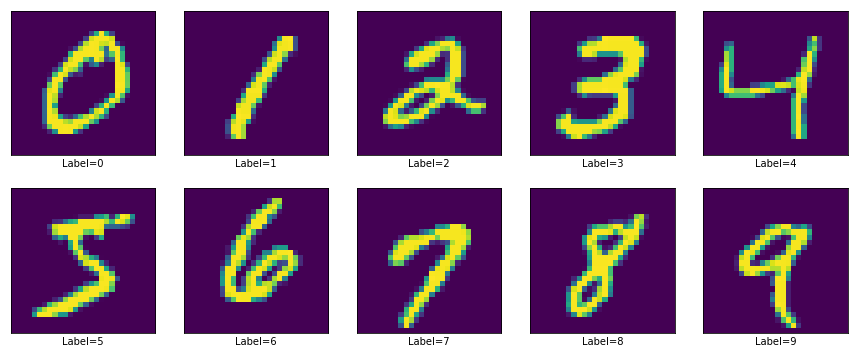

In [2]:
print("The train data set contains {} images with the size of {} * {}.".format(*Train_Imgs.shape))
print("The test data set contains {} images with the size of {} * {}.".format(*Test_Imgs.shape))
print("Here are some sample data point:\n")
f, axes = plt.subplots(2, 5, figsize=(15, 6))
Sample_Indexes=[np.where(Train_Labels==i)[0][0] for i in range(10)]
for i in range(2):
    for j in range(5):
        axes[i,j].imshow(Train_Imgs[Sample_Indexes[i*5+j]])
        axes[i,j].grid(False)
        axes[i,j].set(xlabel="Label={}".format(i*5+j))
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])
        axes[i,j].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)

The distribution of the labels both for the train data set, and for the test data set is uniform.

The data set does not suffer from class imbalance, or shift in distribution from train to test.



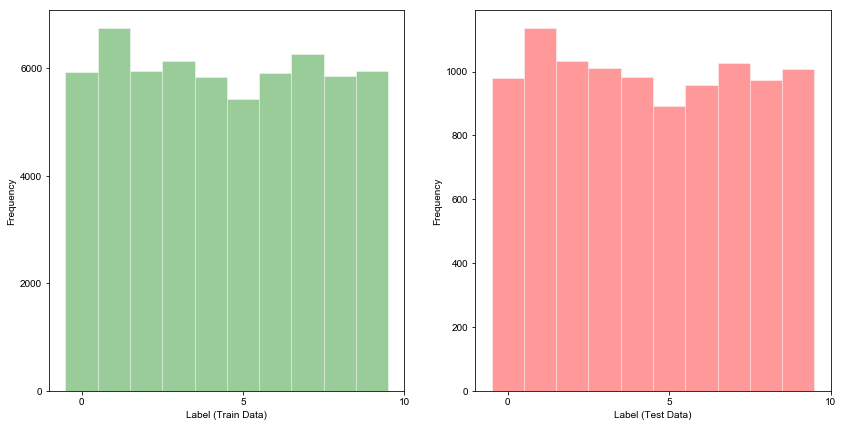

In [3]:
print("The distribution of the labels both for the train data set, and for the test data set is uniform.\n")
print("The data set does not suffer from class imbalance, or shift in distribution from train to test.\n")
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True)
sns.set(font_scale=2.5)
sns.distplot(Train_Labels,kde=False,bins=np.array(range(11))-0.5,ax=axes[0],color="green");
sns.distplot(Test_Labels,kde=False,bins=np.array(range(11))-0.5,ax=axes[1],color='red');
axes[0].set(xlabel="Label (Train Data)",ylabel="Frequency");
axes[1].set(xlabel="Label (Test Data)",ylabel="Frequency");


In [4]:
Batch_size=tf.placeholder(dtype=tf.int64,name="Batch_Size");
Epochs=tf.placeholder(dtype=tf.int64,name="Num_Epochs");
X_Data=tf.placeholder(dtype=tf.float32,shape=[None,28,28],name="Input_Layer");
Y_Data=tf.placeholder(dtype=tf.uint8,name="Label_Layer");
Data_Set_Iter=tf.data.Dataset.from_tensor_slices((X_Data,Y_Data)).repeat(Epochs).batch(batch_size=Batch_size).make_initializable_iterator();
Input_Layer,Label_Layer=Data_Set_Iter.get_next();

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
Onehot_Label=tf.one_hot(Label_Layer,depth=10,dtype=tf.float32)
Expanded_Input=tf.expand_dims(Input_Layer,-1,"Expanded_for_Channel")/255

First_Conv=tf.layers.Conv2D(filters=128,kernel_size=(5,5),activation='relu',strides=1,name="First_Conv")(Expanded_Input)
First_Maxpool=tf.layers.MaxPooling2D(pool_size=(2,2),strides=2,name="First_Maxpool")(First_Conv)

Second_Conv=tf.layers.Conv2D(filters=64,kernel_size=(5,5),activation='relu',strides=1,name="Second_Conv")(First_Maxpool)
Second_Maxpool=tf.layers.MaxPooling2D(pool_size=(2,2),strides=2,name="Second_Maxpool")(Second_Conv)

Third_Conv=tf.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',strides=1,name="Third_Conv")(Second_Maxpool)
Third_Maxpool=tf.layers.MaxPooling2D(pool_size=(2,2),strides=2,name="Third_Maxpool")(Third_Conv)

Flattener=tf.layers.Flatten(name="Flattener")(Third_Maxpool)
First_Dense=tf.layers.Dense(units=10,activation=None,name="First_Dense")(Flattener)


Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=First_Dense, labels=Onehot_Label))
Predict=tf.dtypes.cast(tf.math.argmax(First_Dense,axis=-1),dtype=tf.uint8)
Metric=tf.reduce_mean(tf.dtypes.cast(tf.math.equal(Label_Layer,Predict),dtype=tf.float32))


In [6]:
Optimizer=tf.train.AdamOptimizer()
Task=Optimizer.minimize(Loss)

In [7]:
def print_percent(percent_complete,mode="",accuracy=None):
    import sys
    percent_complete=int(percent_complete)
    tail=""
    if accuracy:
        tail=" Training Accuracy= "+str(accuracy)+"%"
    sys.stdout.write('\r'+mode+"="*percent_complete+'>'+'*'*(100-percent_complete)+ " {}%".format(percent_complete)+tail)

with tf.Session() as sess:
    Batch_Size=128
    Num_Epochs=5
    Percent=0
    Train_Accuracies=[]
    Test_Accuracies=[]
    Prediction=[]
    sess.run(tf.global_variables_initializer())
    
    try:
        Feed_Dict={X_Data:Train_Imgs,Y_Data:Train_Labels,Batch_size:Batch_Size,Epochs:Num_Epochs}
        sess.run(Data_Set_Iter.initializer,feed_dict=Feed_Dict)
        while True:
            _,Train_acc=sess.run([Task,Metric])
            Percent+=Batch_Size/Train_Labels.size/Num_Epochs*100
            print_percent(Percent,accuracy=np.round(Train_acc*100,1))
    
    except tf.errors.OutOfRangeError:
        try:
            sess.run(Data_Set_Iter.initializer,feed_dict={X_Data:Train_Imgs,Y_Data:Train_Labels,Batch_size:1024,Epochs:1})
            while True:
                Train_Accuracies.append(sess.run(Metric))
        except tf.errors.OutOfRangeError:
            try:
                sess.run(Data_Set_Iter.initializer,feed_dict={X_Data:Test_Imgs,Y_Data:Test_Labels,Batch_size:1024,Epochs:1})        
                while True:
                    Prediction.append(sess.run(Predict))
            except tf.errors.OutOfRangeError:
                pass

====================================================================================================> 100% Training Accuracy= 99.0%

In [8]:
from sklearn.metrics import confusion_matrix as CM
Prediction=np.concatenate(Prediction)
cm_log=CM(y_true=Prediction,y_pred=Test_Labels)
cm_log=cm_log/cm_log.sum(axis=1)[:,None]


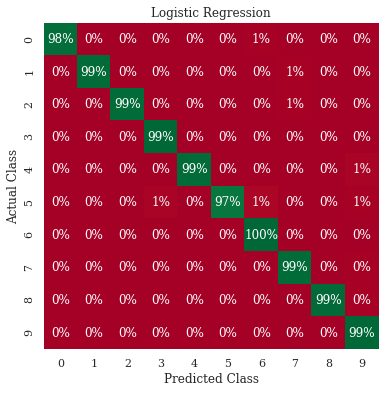

In [9]:
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

sns.set(font="serif",font_scale=1)
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.heatmap(cm_log,cmap="RdYlGn",annot=True,fmt='.0%',cbar=False,ax=ax);
ax.set_xlabel('Predicted Class');
ax.set_ylabel('Actual Class');
ax.set_title('Logistic Regression');